# Load Data

In [2]:
!unzip /content/half_data.zip 

Streaming output truncated to the last 5000 lines.
  inflating: anu/validation/images/003310.3.jpg  
  inflating: anu/validation/images/003933.5.jpg  
  inflating: anu/validation/images/003596.4.jpg  
  inflating: anu/validation/images/003655.0.jpg  
  inflating: anu/validation/images/003365.0.jpg  
  inflating: anu/validation/images/003542.3.jpg  
  inflating: anu/validation/images/003916.5.jpg  
  inflating: anu/validation/images/003432.5.jpg  
  inflating: anu/validation/images/003795.4.jpg  
  inflating: anu/validation/images/003624.0.jpg  
  inflating: anu/validation/images/003474.jpg  
  inflating: anu/validation/images/003237.5.jpg  
  inflating: anu/validation/images/003889.1.jpg  
  inflating: anu/validation/images/003961.4.jpg  
  inflating: anu/validation/images/003647.3.jpg  
  inflating: anu/validation/images/003941.2.jpg  
  inflating: anu/validation/images/003534.jpg  
  inflating: anu/validation/images/003923.jpg  
  inflating: anu/validation/images/003479.4.jpg  
  inf

In [3]:
import os
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.cast(img, tf.float32)/255.0
    return img

## Load Images

In [5]:
train_images = tf.data.Dataset.list_files('/content/anu/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)

In [6]:
val_images = tf.data.Dataset.list_files('/content/anu/validation/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)

## Load Labels

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [10]:
train_labels = tf.data.Dataset.list_files('/content/anu/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('/content/anu/validation/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
len(train_images), len(train_labels), len(val_images), len(val_labels)

(11200, 11200, 2800, 2800)

## Load Dataset

In [53]:
train = tf.data.Dataset.zip((train_images, train_labels)).cache()
train = train.shuffle(len(train_images)//3)
train = train.batch(2)
train = train.prefetch(tf.data.AUTOTUNE)

In [54]:
val = tf.data.Dataset.zip((val_images, val_labels)).cache()
val = val.batch(2)
val = val.prefetch(tf.data.AUTOTUNE)

# Nyoba Model

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D 
from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionV3, Xception, MobileNetV3Large, InceptionResNetV2, MobileNetV3Small   

In [55]:
mobilenetv3s = MobileNetV3Small(include_top=False, input_shape=(200, 200, 3), include_preprocessing=False)
mobilenetv3s.trainable = False

In [56]:
input_layer = Input(shape=(200,200,3))

x = mobilenetv3s(input_layer, training=False)

# Classification Model  
f1 = GlobalAveragePooling2D()(x)
drop1 = Dropout(0.1)(f1)
class2 = Dense(1, activation='sigmoid', name='face')(drop1)

# Bounding box model
f2 = GlobalAveragePooling2D()(x)
drop2 = Dropout(0.1)(f2)
regress2 = Dense(4, activation='sigmoid', name='bbox')(drop2)

model = Model(inputs=input_layer, outputs=[class2, regress2])

In [57]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.93,
  staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, amsgrad=True)

In [ ]:
initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.96,
  staircase=True)

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.99)

In [58]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [59]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)

In [60]:
model.compile(optimizer=opt, loss=['binary_crossentropy', localization_loss],loss_weights=[10, 1] )

In [61]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[callback])

Epoch 1/10
5600/5600 [==============================] - 219s 37ms/step - loss: 4.7438 - face_loss: 0.4344 - bbox_loss: 0.4002 - val_loss: 3.8571 - val_face_loss: 0.3550 - val_bbox_loss: 0.3071
Epoch 2/10
5600/5600 [==============================] - 185s 33ms/step - loss: 3.6346 - face_loss: 0.3334 - bbox_loss: 0.3004 - val_loss: 3.3649 - val_face_loss: 0.3089 - val_bbox_loss: 0.2763
Epoch 3/10
5600/5600 [==============================] - 181s 32ms/step - loss: 3.2839 - face_loss: 0.3012 - bbox_loss: 0.2718 - val_loss: 3.1222 - val_face_loss: 0.2869 - val_bbox_loss: 0.2535
Epoch 4/10
5600/5600 [==============================] - 190s 34ms/step - loss: 3.0841 - face_loss: 0.2827 - bbox_loss: 0.2570 - val_loss: 2.9913 - val_face_loss: 0.2749 - val_bbox_loss: 0.2419
Epoch 5/10
5600/5600 [==============================] - 186s 33ms/step - loss: 2.9891 - face_loss: 0.2741 - bbox_loss: 0.2477 - val_loss: 2.8937 - val_face_loss: 0.2659 - val_bbox_loss: 0.2349
Epoch 6/10
5600/5600 [=============

## Mobilenet v2

### global avg

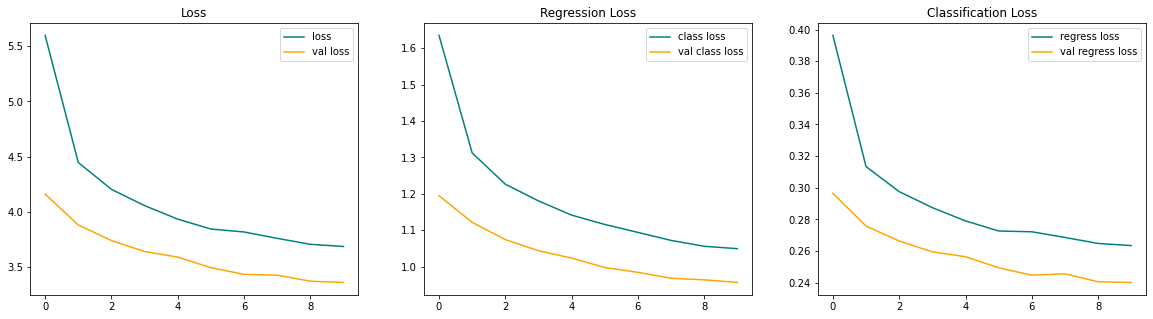

In [ ]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max

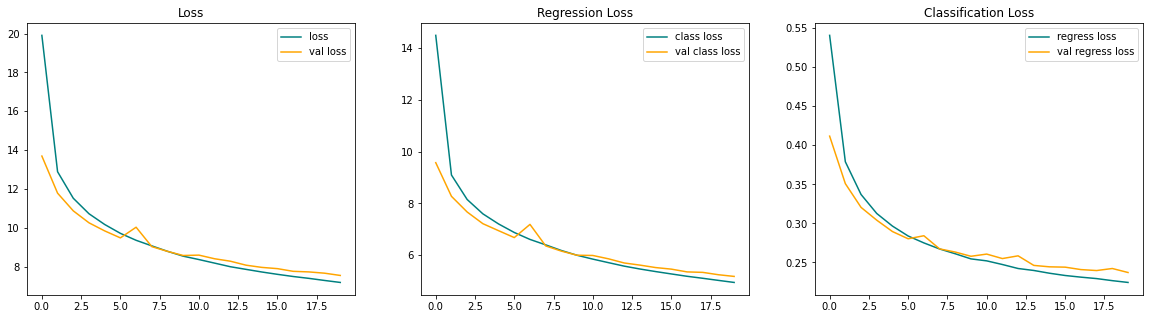

In [ ]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

## Mobilenet v3 small

### global avg sgd

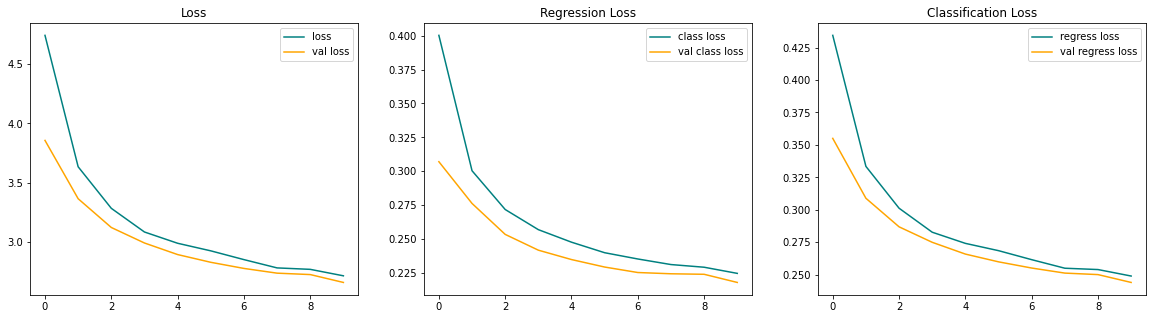

In [62]:
#b2
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

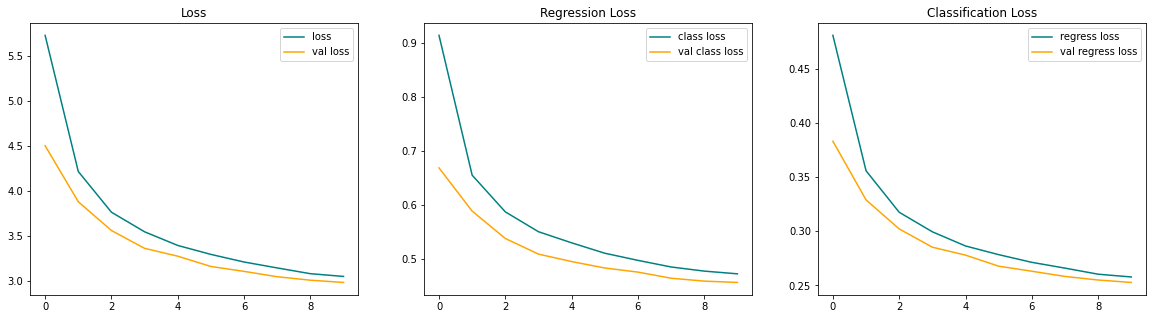

In [50]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global avg adam

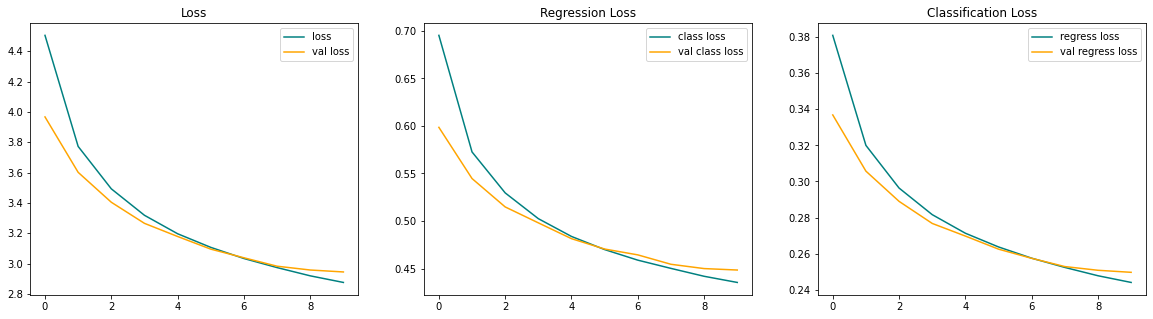

In [27]:
#polos
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

## Mobilenet v3 large

### global avg

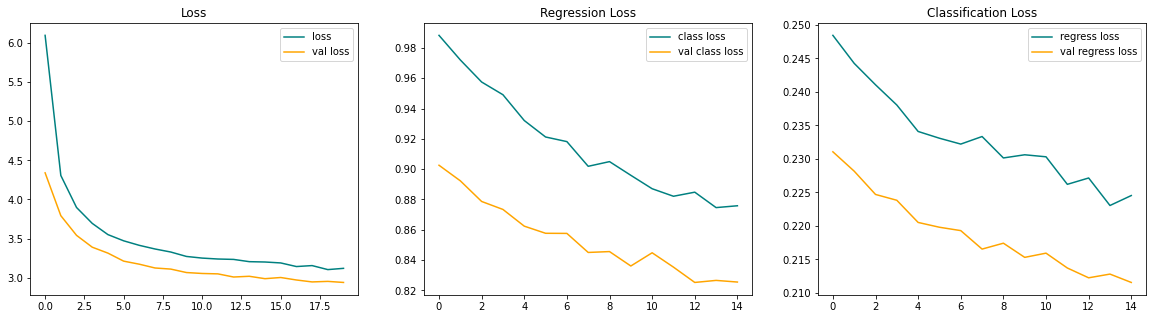

In [ ]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'][5:], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'][5:], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'][5:], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'][5:], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max

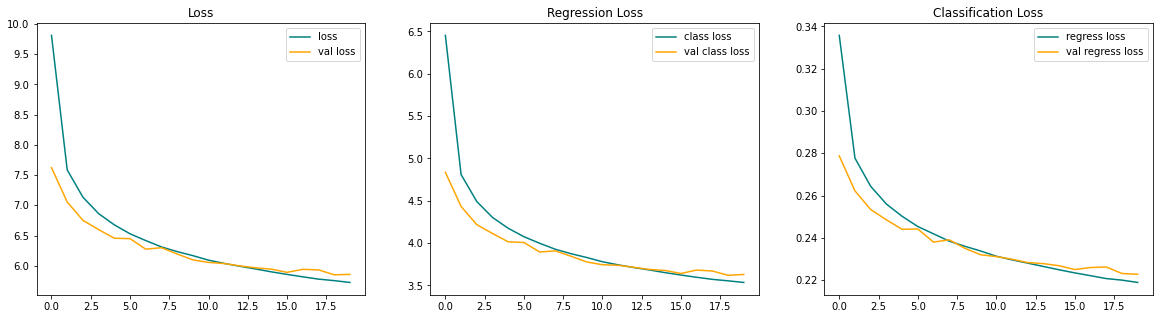

In [ ]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global avg

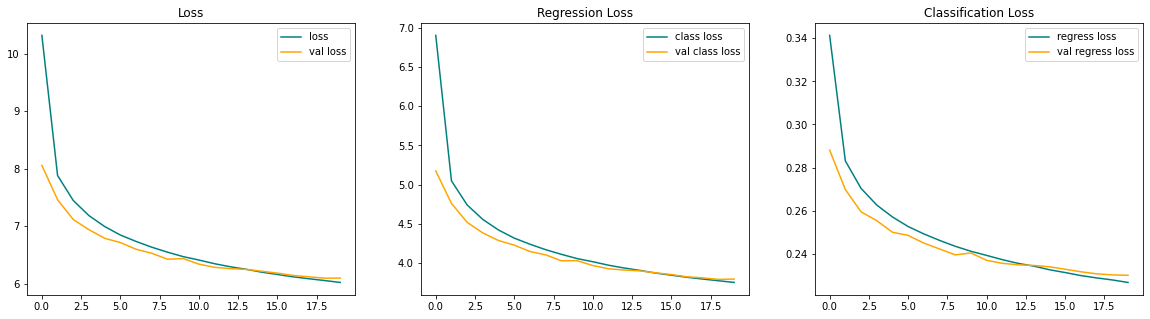

In [ ]:
#mv2 avg 0.0001
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

In [63]:
mobilenetv3s.trainable = True

In [64]:
mobilenetv3s.layers[179]

In [65]:
for layer in mobilenetv3s.layers[:191]:
  layer.trainable = False

In [66]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 7, 7, 576)    939120      ['input_14[0][0]']               
                                                                                                  
 global_average_pooling2d_16 (G  (None, 576)         0           ['MobilenetV3small[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                            

In [67]:
initial_learning_rate = 1e-6
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.96,
  staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, amsgrad=True)
model.compile(optimizer=opt, loss=['binary_crossentropy', localization_loss],loss_weights=[10, 1] )

In [68]:
hist = model.fit(train, epochs=20, initial_epoch=hist.epoch[-1], validation_data=val, callbacks=[callback])

Epoch 10/20
5600/5600 [==============================] - 246s 43ms/step - loss: 2.6441 - face_loss: 0.2425 - bbox_loss: 0.2191 - val_loss: 2.5272 - val_face_loss: 0.2315 - val_bbox_loss: 0.2120
Epoch 11/20
5600/5600 [==============================] - 239s 43ms/step - loss: 2.5132 - face_loss: 0.2297 - bbox_loss: 0.2157 - val_loss: 2.4341 - val_face_loss: 0.2226 - val_bbox_loss: 0.2077
Epoch 12/20
5600/5600 [==============================] - 239s 43ms/step - loss: 2.4074 - face_loss: 0.2195 - bbox_loss: 0.2124 - val_loss: 2.3890 - val_face_loss: 0.2183 - val_bbox_loss: 0.2063
Epoch 13/20
5600/5600 [==============================] - 237s 42ms/step - loss: 2.3525 - face_loss: 0.2143 - bbox_loss: 0.2100 - val_loss: 2.3069 - val_face_loss: 0.2104 - val_bbox_loss: 0.2025
Epoch 14/20
5600/5600 [==============================] - 236s 42ms/step - loss: 2.3028 - face_loss: 0.2096 - bbox_loss: 0.2070 - val_loss: 2.2522 - val_face_loss: 0.2052 - val_bbox_loss: 0.2003
Epoch 15/20
5600/5600 [=======

### global avg fine-tuning

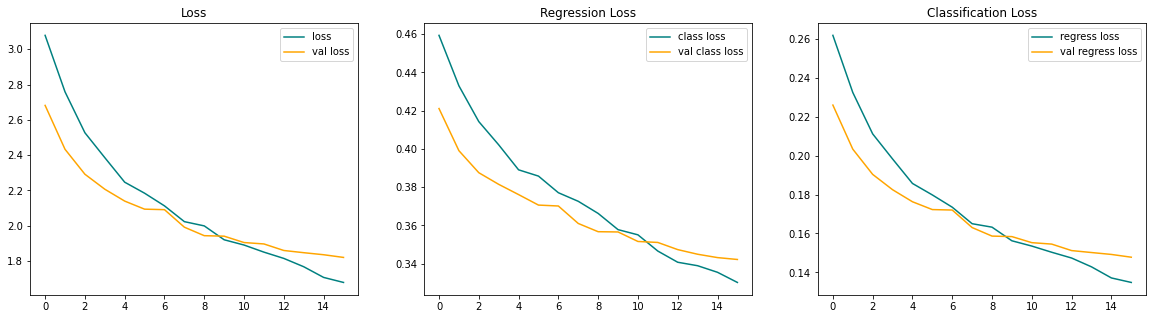

In [ ]:
#mv2 fine
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max fine-tuning

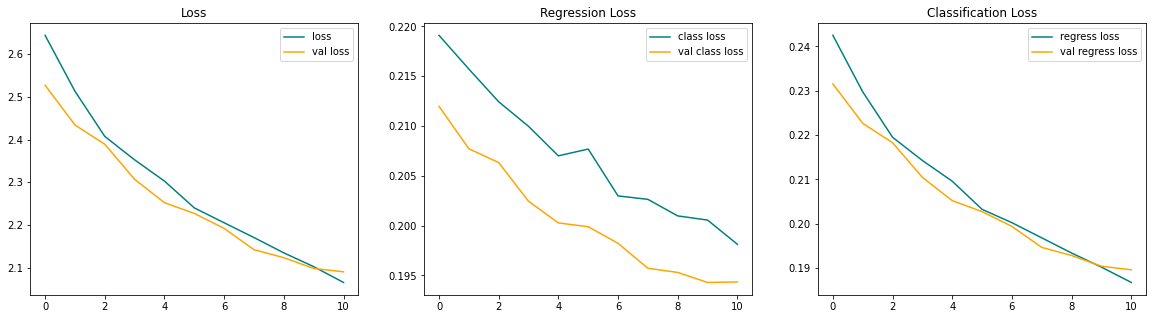

In [69]:
#mv2 fine
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

In [410]:
img = load_image('/content/020743600_1560920290-iStock-469278436.jpg')
img = tf.image.resize(img, [200,200])
img_d = img[np.newaxis, ...]

In [411]:
#ok 33, 20140, 20199, 020217, 020221, 020225, 020318, 020400, 020484, 020607,  kerudung, e57ff57e-8d05-42e8-abc5-03fc4d9a1fa0_169.jpeg, 5562eb4d0423bd48488b4567, 665, 879, jerawat, 020
#no 20147, nikita, 3be

In [412]:
yhat = model.predict(img_d)

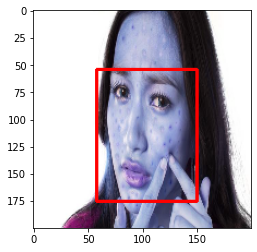

In [413]:
import cv2 
   
# path 
path = r'/content/020743600_1560920290-iStock-469278436.jpg'
   
# Reading an image in default mode
image = cv2.imread(path)
image = cv2.resize(image, (200, 200))
   
# Window name in which image is displayed
window_name = 'Image'
  
# Start coordinate, here (5, 5)
# represents the top left corner of rectangle
#start_point = tuple(np.multiply(yhat[1][0][:2], [200,200]).astype(int))
start_point = tuple(np.multiply(yhat[1][0][:2], [200,200]).astype(int) - np.array([21, 18]))
  
# Ending coordinate, here (220, 220)
# represents the bottom right corner of rectangle
#end_point = tuple(np.multiply(yhat[1][0][2:], [200,200]).astype(int))
end_point = tuple(np.multiply(yhat[1][0][2:], [200,200]).astype(int) - np.array([35, 18]))
  
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
  
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image = cv2.rectangle(image, start_point, end_point, color, thickness)
  
# Displaying the image 
plt.imshow(image) 

In [267]:
model.save('model_v3.h5')

In [ ]:
val_data = val.as_numpy_iterator()

In [ ]:
val_sample = val_data.next()

In [ ]:
yhat = model.predict(val_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


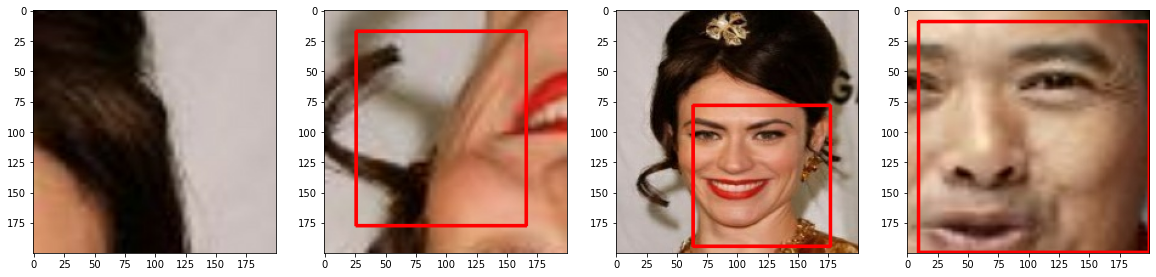

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
idx = 0

for i in range(4):
    sample_image = val_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [200,200]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [200,200]).astype(int)), 
                            (255,0,0), 2)
    ax[i].imshow(sample_image)
    idx += 1

# for idx in range(16):
#     sample_image = test_sample[0][idx]
#     sample_coords = yhat[1][idx]
    
#     if yhat[0][idx] > 0.9:
#         cv2.rectangle(sample_image, 
#                       tuple(np.multiply(sample_coords[:2], [100,120]).astype(int)),
#                       tuple(np.multiply(sample_coords[2:], [100,120]).astype(int)), 
#                             (255,0,0), 2)
#     ax[idx].imshow(sample_image)

In [414]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('model_v3')

INFO:tensorflow:Assets written to: model_v2_keras\assets


E:\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
tf.saved_model.save(model, 'model_v2')

INFO:tensorflow:Assets written to: model_v2\assets


In [418]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_v3') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_v3.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
loaded = tf.saved_model.load('model')
print(list(loaded.signatures.keys()))

['serving_default']


In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
savedModel = model.load_weights('model_weights.h5')
print('Model Loaded!')

Model Loaded!


In [416]:
model = load_model('model_v3', custom_objects={'localization_loss': localization_loss})

In [417]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 7, 7, 576)    939120      ['input_14[0][0]']               
                                                                                                  
 global_average_pooling2d_16 (G  (None, 576)         0           ['MobilenetV3small[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                            

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model model_v2_keras web_model

Writing weight file web_model\model.json...


2022-05-26 18:10:15.372233: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-26 18:10:22.368488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2149 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-05-26 18:10:46.921161: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-05-26 18:10:46.942835: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-05-26 18:10:47.298757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 w

In [268]:
!zip -r model_v3.zip model_v3

  adding: model_v3/ (stored 0%)
  adding: model_v3/keras_metadata.pb (deflated 95%)
  adding: model_v3/saved_model.pb (deflated 91%)
  adding: model_v3/assets/ (stored 0%)
  adding: model_v3/variables/ (stored 0%)
  adding: model_v3/variables/variables.index (deflated 74%)
  adding: model_v3/variables/variables.data-00000-of-00001 (deflated 8%)
